# Simulate MR Signal for a transient-state, gradient-balanced sequence with a Cartesian k-space trajectory

In this example we are going to generate a phantom
and simulate the signal for a gradient-balanced sequence
with a Cartesian gradient trajectory

In [3]:
using BlochSimulators
using ComputationalResources
using StaticArrays
using LinearAlgebra
using PythonPlot
using FFTW
import ImagePhantoms

In [4]:
# First we assemble a Shepp Logan phantom with homogeneous T₁ and T₂
# but non-constant proton density and B₀
N = 256
ρ = complex.(ImagePhantoms.shepp_logan(N, ImagePhantoms.SheppLoganEmis())');
ρˣ = real.(ρ)
ρʸ = imag.(ρ)
T₁ = fill(0.85, N, N);
T₂ = fill(0.05, N, N);
B₀ = repeat(1:N, 1, N);

# Assemble the phantom (as a `StructArray` of `T₁T₂B₀ρˣρʸ` values) 
# using the @parameters macro from BlochSimulators
parameters = @parameters T₁ T₂ B₀ ρˣ ρʸ

256×256 StructArray(::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Int64}, ::Matrix{Float32}, ::Matrix{Float32}) with eltype T₁T₂B₀ρˣρʸ{Float64}:
 [0.85, 0.05, 1.0, 0.0, 0.0]    …  [0.85, 0.05, 1.0, 0.0, 0.0]
 [0.85, 0.05, 2.0, 0.0, 0.0]       [0.85, 0.05, 2.0, 0.0, 0.0]
 [0.85, 0.05, 3.0, 0.0, 0.0]       [0.85, 0.05, 3.0, 0.0, 0.0]
 [0.85, 0.05, 4.0, 0.0, 0.0]       [0.85, 0.05, 4.0, 0.0, 0.0]
 [0.85, 0.05, 5.0, 0.0, 0.0]       [0.85, 0.05, 5.0, 0.0, 0.0]
 [0.85, 0.05, 6.0, 0.0, 0.0]    …  [0.85, 0.05, 6.0, 0.0, 0.0]
 [0.85, 0.05, 7.0, 0.0, 0.0]       [0.85, 0.05, 7.0, 0.0, 0.0]
 [0.85, 0.05, 8.0, 0.0, 0.0]       [0.85, 0.05, 8.0, 0.0, 0.0]
 [0.85, 0.05, 9.0, 0.0, 0.0]       [0.85, 0.05, 9.0, 0.0, 0.0]
 [0.85, 0.05, 10.0, 0.0, 0.0]      [0.85, 0.05, 10.0, 0.0, 0.0]
 ⋮                              ⋱  ⋮
 [0.85, 0.05, 248.0, 0.0, 0.0]     [0.85, 0.05, 248.0, 0.0, 0.0]
 [0.85, 0.05, 249.0, 0.0, 0.0]     [0.85, 0.05, 249.0, 0.0, 0.0]
 [0.85, 0.05, 250.0, 0.0, 0.0]     [0.85, 0.05, 250.0, 0

In [5]:
# We also set the spatial coordinates for the phantom
FOVˣ, FOVʸ = 25.6, 25.6;
X = LinRange(-FOVˣ / 2, FOVˣ / 2, N) # [x for x ∈ LinRange(-FOVˣ / 2, FOVˣ / 2, N), y ∈ 1:N];
Y = LinRange(-FOVʸ / 2, FOVʸ / 2, N) # [y for x ∈ 1:N, y ∈ LinRange(-FOVʸ / 2, FOVʸ / 2, N)];
Z = LinRange(0, 0, 1)

# Use the `@coordinates` macro from BlochSimulators to assemble the coordinates in the right format
coordinates = @coordinates X Y Z

65536-element StructArray(::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}) with eltype Coordinates{Float64}:
 Coordinates{Float64}(-12.8, -12.8, 0.0)
 Coordinates{Float64}(-12.699607843137255, -12.8, 0.0)
 Coordinates{Float64}(-12.599215686274512, -12.8, 0.0)
 Coordinates{Float64}(-12.498823529411766, -12.8, 0.0)
 Coordinates{Float64}(-12.398431372549021, -12.8, 0.0)
 Coordinates{Float64}(-12.298039215686273, -12.8, 0.0)
 Coordinates{Float64}(-12.19764705882353, -12.8, 0.0)
 Coordinates{Float64}(-12.097254901960785, -12.8, 0.0)
 Coordinates{Float64}(-11.996862745098039, -12.8, 0.0)
 Coordinates{Float64}(-11.896470588235296, -12.8, 0.0)
 ⋮
 Coordinates{Float64}(11.996862745098039, 12.8, 0.0)
 Coordinates{Float64}(12.097254901960785, 12.8, 0.0)
 Coordinates{Float64}(12.19764705882353, 12.8, 0.0)
 Coordinates{Float64}(12.298039215686273, 12.8, 0.0)
 Coordinates{Float64}(12.39843137254902, 12.8, 0.0)
 Coordinates{Float64}(12.498823529411766, 12.8, 0.0)
 Coordinates{Float64}(12.5992

In [6]:
# Next, we assemble a balanced sequence with constant flip angle of 60 degrees,
# a TR of 10 ms and 0-π phase cycling. See `src/sequences/pssfp.jl` for the
# sequence description and the fields for which values must be provided

nTR = N
RF_train = complex.(fill(90.0, nTR)) # constant flip angle train
RF_train[2:2:end] .*= -1 # 0-π phase cycling
nRF = 25 # nr of RF discretization points
durRF = 0.001 # duration of RF excitation
TR = 0.010 # repetition time
TI = 20.0 # long inversion delay -> no inversion
gaussian = [exp(-(i - (nRF / 2))^2 * inv(nRF)) for i ∈ 1:nRF] # RF excitation waveform
γΔtRF = (π / 180) * normalize(gaussian, 1) |> SVector{nRF} # normalize to flip angle of 1 degree
Δt = (ex=durRF / nRF, inv=TI, pr=(TR - durRF) / 2); # time intervals during TR
γΔtGRz = (ex=0.002 / nRF, inv=0.00, pr=-0.01); # slice select gradient strengths during TR
nz = 35 # nr of spins in z direction
z = SVector{nz}(LinRange(-1, 1, nz)) # z locations

sequence = pSSFP2D(RF_train, TR, γΔtRF, Δt, γΔtGRz, z)

pSSFP2D sequence
RF_train: Vector{ComplexF64}
TR:       0.01
γΔtRF:    SVector{25}{Float64}
Δt:       (ex = 4.0e-5, inv = 20.0, pr = 0.0045000000000000005)
γΔtGRz:   (ex = 8.0e-5, inv = 0.0, pr = -0.01)
z:        SVector{35}{Float64}


In [7]:
# Next, we assemble a 2D Cartesian trajectory with linear phase encoding
# (see `src/trajectories/cartesian.jl`).

nr = nTR # nr of readouts
ns = N # nr of samples per readout
Δt_adc = 10^-5 # time between sample points
py = -(N ÷ 2):1:(N÷2)-1 # phase encoding indices
py = repeat(py, nr ÷ N)
Δkˣ = 2π / FOVˣ; # k-space step in x direction for Nyquist sampling
Δkʸ = 2π / FOVʸ; # k-space step in y direction for Nyquist sampling
k0 = [(-ns / 2 * Δkˣ) + im * (py[r] * Δkʸ) for r in 1:nr]; # starting points in k-space per readout

trajectory = CartesianTrajectory2D(nr, ns, Δt_adc, k0, Δkˣ, py, 1)

Cartesian trajectory 2D
nreadouts:            256
nsamplesperreadout:   256
Δt:                   1.0e-5
k_start_readout:      Vector{ComplexF64}
Δk_adc:               0.2454369260617026
py:                   Vector{Int64}
readout_oversampling: 1


In [8]:
# We use two different receive coils during the simulations
coil₁ = complex.(repeat(LinRange(0.5, 1.0, N), 1, N));
coil₂ = coil₁';

coil_sensitivities = [vec(coil₁) ;; vec(coil₂)]

65536×2 Matrix{ComplexF64}:
      0.5+0.0im  0.5-0.0im
 0.501961+0.0im  0.5-0.0im
 0.503922+0.0im  0.5-0.0im
 0.505882+0.0im  0.5-0.0im
 0.507843+0.0im  0.5-0.0im
 0.509804+0.0im  0.5-0.0im
 0.511765+0.0im  0.5-0.0im
 0.513725+0.0im  0.5-0.0im
 0.515686+0.0im  0.5-0.0im
 0.517647+0.0im  0.5-0.0im
         ⋮       
 0.984314+0.0im  1.0-0.0im
 0.986275+0.0im  1.0-0.0im
 0.988235+0.0im  1.0-0.0im
 0.990196+0.0im  1.0-0.0im
 0.992157+0.0im  1.0-0.0im
 0.994118+0.0im  1.0-0.0im
 0.996078+0.0im  1.0-0.0im
 0.998039+0.0im  1.0-0.0im
      1.0+0.0im  1.0-0.0im

In [9]:
# Now we want to simulate the signal for the sequence, trajectory, phantom and coils on GPU

# Specify the resource
resource = CUDALibs()

# Convert all objects to single precision and send to CUDA device
sequence = gpu(f32(sequence))
parameters = gpu(f32(parameters)) |> vec
trajectory = gpu(f32(trajectory))
coil_sensitivities = gpu(f32(coil_sensitivities))
coordinates = gpu(f32(coordinates)) |> vec

ErrorException: CUDA driver not found

In [ ]:
# To calclate the signal, we first compute magnetization at echo times in all voxels
CUDA.@time magnetization = simulate_magnetization(resource, sequence, parameters);

# Then we apply phase encoding (typically only for Cartesian trajectories)
CUDA.@time phase_encoding!(magnetization, trajectory, coordinates)

# Finally, we compute signal from (phase-encoded) magnetization at echo times
CUDA.@time signal = magnetization_to_signal(resource, magnetization, parameters, trajectory, coordinates, coil_sensitivities);

In [ ]:
# Alternatively, we can use the simulate_signal function which combines the above three steps into one
CUDA.@time signal = simulate_signal(resource, sequence, parameters, trajectory, coordinates, coil_sensitivities);

In [ ]:
# Let's do it again to see the actual runtime without compilation
CUDA.@time signal = simulate_signal(resource, sequence, parameters, trajectory, coordinates, coil_sensitivities);

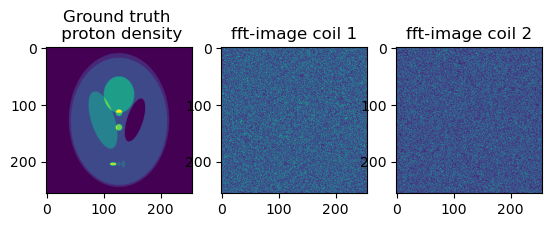

In [ ]:
# Let's look at fft images of the signals from the two different coils

# Send the signal from GPU back to CPU
signal = collect(signal)

signal₁ = signal[:, :, 1]
signal₂ = signal[:, :, 2]

@. signal₁[2:2:end] *= -1 # correct for phase cycling
@. signal₂[2:2:end] *= -1 # correct for phase cycling

fft_image₁ = rot180(ifft(reshape(signal₁, N, N))) # rot180 instead of fftshifts
fft_image₂ = rot180(ifft(reshape(signal₂, N, N))) # rot180 instead of fftshifts

figure()
subplot(1, 3, 1);
imshow(abs.(ρ));
title("Ground truth \n proton density");
subplot(1, 3, 2);
imshow(abs.(fft_image₁));
title("fft-image coil 1");
subplot(1, 3, 3);
imshow(abs.(fft_image₂));
title("fft-image coil 2");

display(gcf())

In [16]:
fft_image₁

256×256 Matrix{ComplexF64}:
  11.6548-20.6157im    7.89058-15.2735im   …    11.8223+2.48578im
 0.423512-2.31369im    -6.8398-10.8629im        15.9443-0.562263im
   1.8448-14.4015im    10.4846+0.618804im       6.76201+2.32708im
  5.51227-4.87664im   -2.69738+3.89495im        14.8687-1.26996im
 0.340031+7.38963im    11.5867+1.38966im        8.77471-13.8954im
 -6.27819+3.41826im   -6.98513-10.4613im   …  -0.842821-4.65753im
 -19.0373+8.263im     -8.48584+13.8838im       -3.77789+1.02919im
  11.1912+5.97054im   -10.9616-5.86546im       -3.02296-8.48438im
  8.76625+3.08287im   -7.49727-9.65498im       -11.2182-5.9664im
 -5.44247+10.2554im   -1.98038+7.42905im       -7.15656+11.1424im
         ⋮                                 ⋱           ⋮
 -1.76564+8.33541im    17.0534+3.95331im       -3.02296+8.48438im
  2.82041+10.4787im    8.97177-5.56455im       -3.77789-1.02919im
 -11.9413+4.34095im   0.558985-5.8768im       -0.842821+4.65753im
  2.08402-4.42691im    21.4029-10.904im    …    8.77471+1